# Gaia DR3 Hackaton @ MIT
## Action-Angle Coordinates Tutorial

In this tutorial, we will use Agama to compute the *action-angle coordinates*. 

### Background

- The instantaneous state of each star is given by its **phase space** coordinate, which consists of the 3 spatial coordinates and 3 momenta $(\vec{x}, \vec{p}=m\vec{v})$. 

- Because $(\vec{x}, \vec{p})$ change as a function of time $t$, they are sometimes not helpful for understanding the orbits of the stars.

- Instead, we opt to characterize an orbit using its **integrals of motion**, which usually stay constant.

- In Hamiltonian mechanics, for systems with period equation of motions (such as the Milky Way), we replace the momenta with the **action variable**, defined by the integral:

 \begin{equation}
    J_i \equiv \oint p_i d x_i
 \end{equation}
 
 where, for each pair of coordinate $(x_i, p_i)$, the integral is taken over one complete period of oscillation.
 We see that the action $J_i$ has the same unit with angular momentum, which is $\mathrm{length}^2/\mathrm{time}$.

- The coordinate conjugate to $J_i$ is the **angle variable**, related to $J_i$ via the Hamiltonia equation:

 \begin{equation}
     \omega_i = \frac{\partial H}{\partial J}
 \end{equation}

#### Resources:

- [Lecture Note by Douglas Cline](https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Variational_Principles_in_Classical_Mechanics_(Cline)/15%3A_Advanced_Hamiltonian_Mechanics/15.05%3A_Action-angle_Variables)

- [MIT OWC 8.09 Lecture Note](https://ocw.mit.edu/courses/8-09-classical-mechanics-iii-fall-2014/f00f7f68ac7ba346a0868efb7430582c_MIT8_09F14_Chapter_4.pdf)

- [*Galactic Dynamics: Second Edition* by James Binney and Scott Tremaine](https://www.amazon.com/Galactic-Dynamics-Second-Princeton-Astrophysics/dp/0691130272)


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from IPython.display import HTML, display

import agama

%matplotlib inline

# Set unit of Agama to (mass, length, velocity) = (1 Msun, 1 kpc, 1 km/s)
agama.setUnits(mass=1, length=1, velocity=1)

mpl.rcParams.update({
    'font.size': 20,
    'figure.figsize': (8, 6),
    'figure.facecolor': 'w',
    'axes.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

### Milky Way Potential
Because the action-angle coordinates are integrals of motions, to estimate them, we have to trace the orbit of each star (via a process called *orbit integration*).
Orbit integration requires knowledge of the potential $\Phi$ of the Milky Way.
We assume a static potential (constant in time) and use the `MWPotential2014` model described in [Bovy 2014](https://arxiv.org/pdf/1412.3451.pdf).


In [Bovy 2014](https://arxiv.org/pdf/1412.3451.pdf), the Milky Way potential is estimate to made up of three main components: a dark matter halo, a spherical bulge, and a disk (see schematic below):


<div>
<img src="images/Milky-Way-structure.png" width="350"/>
</div>
<center> 
A schematic of the Milky Way. 
Credit: CalPoly <a href="https://evolution.calpoly.edu/milky-way-galaxy">https://evolution.calpoly.edu/milky-way-galaxy</a>
</center>


- **Dark Matter Halo**: described by a Navarro-Frenk-White (NFW) spherical density profile

 \begin{equation}
    \rho_\mathrm{halo}(r) = \left(8.49 \times 10^6 \, \frac{\mathrm{M_\odot}}{\mathrm{kpc^3}}\right) 
    \left(\frac{r}{16 \, \mathrm{kpc}}\right)^{-1} 
    \left(1 + \frac{r}{16 \, \mathrm{kpc}}\right)^{-2}
 \end{equation}

 where $r$ is the spherical radius.

- **Galactic Bulge**: described by a power-law density with an exponential cut-off

 \begin{equation}
    \rho_\mathrm{bulge}(r) = \left(2.23 \times 10^8 \, \frac{\mathrm{M_\odot}}{\mathrm{kpc^3}}\right) 
    \,\left(\frac{r}{1 \, \mathrm{kpc}}\right)^{-1.8}\,\exp\left[-\left(\frac{r}{1.9 \, \mathrm{kpc}}\right)^2\right]
 \end{equation}

 where $\rho_1$ is the central density, $r_1$ is the scale radius, and $r_c$ is the cut-off radius.
 The potential of the bulge may be calculated from the enclosed mass $M_\mathrm{enc}(r)$

 \begin{equation}
    \Phi_\mathrm{spherioid}(r) = - \frac{G M_\mathrm{enc}(r)}{r}, 
    \quad \mathrm{where} \quad 
    M_\mathrm{enc}(r) = \int_0^r \rho(\mathrm{\tilde{r}}) \, 4\pi \tilde{r}^2 \, d\tilde{r}
 \end{equation}


- **Disk**: described by the Miyamoto-Nagai potential model ([Miyamoto & Nagai 1975](https://ui.adsabs.harvard.edu/abs/1975PASJ...27..533M/abstract)):

 \begin{equation}
    \Phi_\mathrm{disk}(R, z) = - \frac{GM}{\sqrt{R^2 + \left(\sqrt{z^2 + b^2} + a\right)^2}}
 \end{equation}

 where $R$ is the cylindrical radius, $z$ is the height, $M=6.82 \times 10^{10} \, M_\odot$ is the total mass of the disk, $b=0.28 \, \mathrm{kpc}$ is the scale height, and $a = 3 \, \mathrm{kpc}$ is the scale length.

In [3]:
# Read in the potential of the Milky Way
potential = agama.Potential(file='data/MWPotential2014.ini')

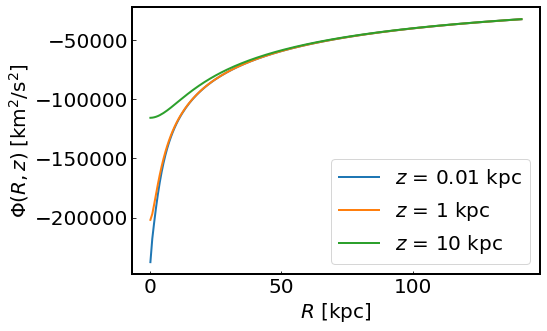

In [46]:
# Plot the potential at different cylindrical radius and different height
fig, ax = plt.subplots(1, figsize=(8, 5))

r_max = 100
X = np.linspace(0.1, r_max, 200)
Y = np.linspace(0.1, r_max, 200)
R = np.sqrt(X**2 + Y**2)

for z in [0.01, 1, 10]:
    Z = np.ones_like(X) * z
    simulated_pos = np.stack([X, Y, Z], axis=1)    
    pot = potential.potential(simulated_pos)
    ax.plot(R, pot, label=f'$z$ = {z} kpc', lw=2)
    
ax.set_ylabel(r'$\Phi(R, z) \; [\mathrm{km}^2 / \mathrm{s}^2]$', fontsize=20)
ax.set_xlabel('$R$ [kpc]', fontsize=20)
ax.legend(loc=4)

fig.tight_layout()

## Calculate the cylindrical action


In [6]:
action_finder = agama.ActionFinder(potential)

In [7]:
N = 100000
x_rand = np.random.uniform([0, 0, 0], [20, 20, 20], size=(N, 3))
v_rand = np.random.uniform([0, 0, 0], [200, 200, 10], size=(N, 3))
xv_rand = np.hstack([x_rand, v_rand])

unit_conversion = (u.kpc * u.km / u.s).to(u.kpc**2 / u.Myr)
Jr, Jz, Jphi = action_finder(xv_rand).T * unit_conversion

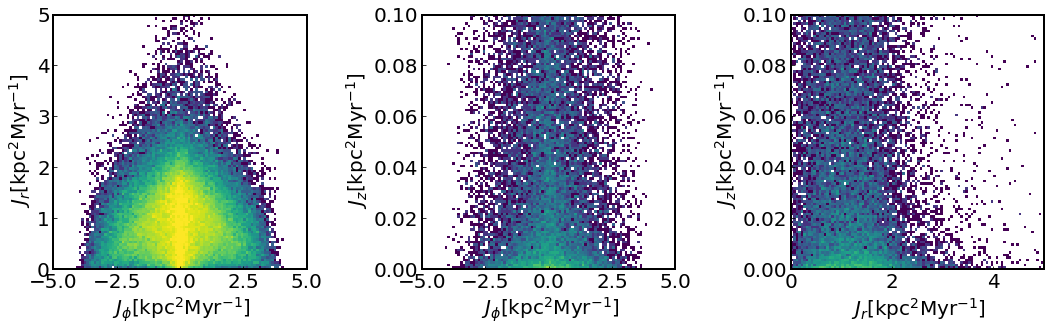

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

hist_range = ((0, 5), (0, 0.1), (-5, 5))
norm = mpl.colors.LogNorm(vmin=1, vmax=100)
bins = 100

select = ~(np.isnan(Jr) | (np.isnan(Jz)) | np.isnan(Jphi))
axes[0].hist2d(
    Jphi[select], Jr[select], bins=(bins, bins), 
    range=(hist_range[2], hist_range[0]), norm=norm)
axes[1].hist2d(
    Jphi[select], Jz[select], bins=(bins, bins), 
    range=(hist_range[2], hist_range[1]), norm=norm)
axes[2].hist2d(
    Jr[select], Jz[select], bins=(bins, bins), 
    range=(hist_range[0], hist_range[1]), norm=norm)


axes[0].set_xlabel(r' $J_\phi [\mathrm{kpc}^2 \mathrm{Myr}^{-1}]$')
axes[1].set_xlabel(r' $J_\phi [\mathrm{kpc}^2 \mathrm{Myr}^{-1}]$')
axes[2].set_xlabel(r' $J_r [\mathrm{kpc}^2 \mathrm{Myr}^{-1}]$')
axes[0].set_ylabel(r' $J_r [\mathrm{kpc}^2 \mathrm{Myr}^{-1}]$')
axes[1].set_ylabel(r' $J_z [\mathrm{kpc}^2 \mathrm{Myr}^{-1}]$')
axes[2].set_ylabel(r' $J_z [\mathrm{kpc}^2 \mathrm{Myr}^{-1}]$')

fig.tight_layout()